In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

GPU available: Tesla T4


## LSTM

In this case of study, I have used the LSTM for prediction. Compared with more complex model, the strength of this model is that it achieves high accuracy in this specific dataset through long-term training or large number of epochs to obtain high-quality predicted photos, as more complex models may require more time on training. Though the trend of this training process is going to overfiiting, but in this particular case, this seems not to be a real problem as large dataset of the surprise storm is provided for training.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from matplotlib.image import imread
!pip install livelossplot
from livelossplot import PlotLosses
from glob import glob
from concurrent.futures import ThreadPoolExecutor
import cv2


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os
import json

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Load the images

In [4]:
files = sorted(glob('/content/drive/MyDrive/tst/*.jpg'))
images = []
for filepath in files:
  img = np.array(Image.open(filepath))
  images.append(img)

dataset = np.array(images)

In [5]:
# Parameter for dataloader and model parameters
num_images = 250
pca_components = 200
feature_size1 = 40
feature_size2 = 5
X_dataset = dataset[:num_images]

### PCA process with components = 200

In [6]:
# minmax scaling
X_min = (X_dataset - X_dataset.min()) / (X_dataset.max() - X_dataset.min())

#X_normalized = (X_dataset - X_dataset.mean()) / X_dataset.std()

X_flattened = X_min.reshape(num_images, -1)

pca = PCA(n_components=pca_components)
X_pca = pca.fit_transform(X_flattened)
X_train = X_pca.reshape(num_images, feature_size1, feature_size2)

In [7]:
# Hyper-parameters
sequence_length = 5
input_size = feature_size1*feature_size2
hidden_size = 1024
num_layers = 3
num_feature = feature_size1*feature_size2*sequence_length
batch_size = 5
num_epochs = 400
learning_rate = 0.0001

### Forming the customized dataset and LSTM model

In [8]:
class TensorDataset(Dataset):
    def __init__(self, data, transform=None, sequence_length= sequence_length):
        """
        Args:
            sequence_length: the number of images using in one combanation for prediction
        """
        self.sequence_length = sequence_length
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        if self.transform:
            # use the number which equals to sequence_length of images to predict the next target like moving window
            sample = torch.stack([self.transform(self.data[idx+i]) for i in range(self.sequence_length)])
            sample = torch.transpose(sample, 0, 1)
            target = torch.stack([self.transform(self.data[idx+i+1]) for i in range(self.sequence_length)])
            target = torch.transpose(target, 0, 1)
        return sample.float(), target.float()

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_feature):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, 800)
        self.fc = nn.Linear(800, num_feature)
        # self.act = nn.ReLU()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.linear(out[-1, :, :])
        out = self.fc(out)
        out = out.reshape(-1, sequence_length, input_size)
        return out

In [10]:
def train_model(epoch, model, train_loader, criterion, optimizer,device='cuda'):
  train_loss = 0
  model.train()
  for i, (input, target) in enumerate(train_loader):
    input = input.reshape(-1, sequence_length, input_size).to(device)
    target = target.reshape(-1, sequence_length, input_size).to(device)
    outputs = model(input)

    loss = criterion(outputs, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * input.size(0)

  train_loss /= len(train_loader.dataset)
  return train_loss

def validate_model(model, val_loader):

  val_loss = 0
  model.eval()

  with torch.no_grad():
      for input, target in val_loader:
          input = input.reshape(-1, sequence_length, input_size).to(device)
          target = target.reshape(-1, sequence_length, input_size).to(device)

          outputs = model(input)

          loss = criterion(outputs, target)
          val_loss += loss.item() * input.size(0)

  val_loss /= len(val_loader.dataset)
  return val_loss

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = TensorDataset(X_train, transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

### Model training using LSTM

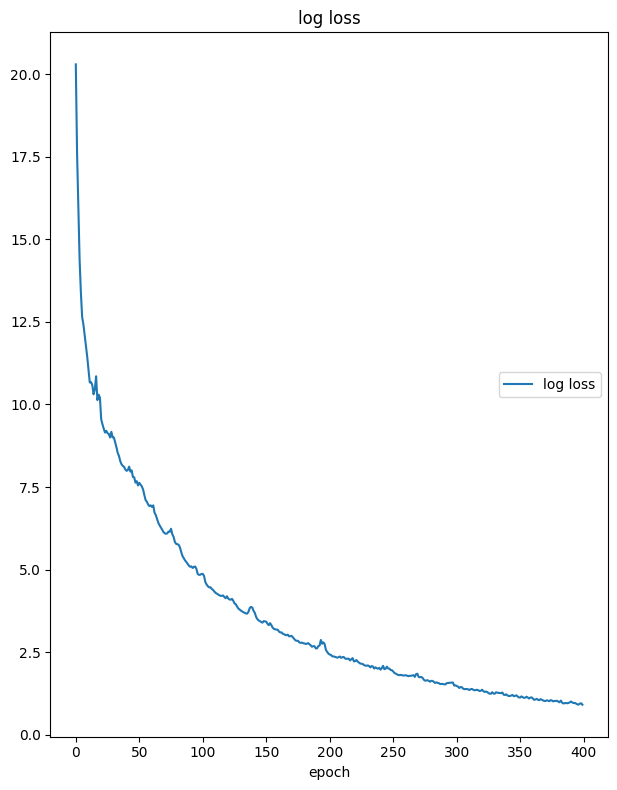

log loss
	log loss         	 (min:    0.914, max:   20.293, cur:    0.914)
Epoch:399: Training Loss:0.9142516000



In [12]:
model = LSTM(input_size, hidden_size, num_layers, num_feature).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Plot the loss for the training part, as in this case of study the overfitting might not be a problem
liveloss = PlotLosses()
for epoch in range(num_epochs):

  logs = {}
  train_loss = train_model(epoch,model, train_loader, criterion, optimizer, device=device)
 # val_loss = validate_model(model, val_loader)

  logs['' + 'log loss'] = train_loss
  #logs['val_' + 'log loss'] = val_loss

  liveloss.update(logs)
  liveloss.draw()
  print("Epoch:{}: Training Loss:{:.10f}\n".format(epoch, train_loss))

  # print("Epoch:{}: Training Loss:{:.10f};  Validation Loss:{:.10f}\n".format(epoch, train_loss,val_loss))


In [15]:
# Predicting the image in the sequence_length, each time reduce the number of the predcting image in the batch to create difference

model.to(device)
# Create the copy for train and pca dataset preventing data corruption
X_train_copy = X_train
X_pca_copy = X_pca
for i in range(sequence_length):
    X_last = np.array(X_train_copy[-sequence_length+i:].reshape(1,sequence_length-i, pca_components))
    # Convert to a PyTorch tensor and move to the GPU
    X_last = torch.tensor(X_last).float().to(device)
    model.eval()
    with torch.no_grad():
        pred_lat = model(X_last)
        # Use the last image in the target image batch as the predicting one
        pred_lat = pred_lat[-1][-1].reshape(1, input_size)

        pred_lat = pred_lat.cpu().detach().numpy().reshape(1, input_size)
        # Apend the predicting image to pca dataset for further tranform
        X_pca_copy = np.append(X_pca_copy, pred_lat, axis=0)
        X_train_copy = X_pca_copy.reshape(num_images+1+i, pca_components, 1)

### Showing the final result:<br>
In this case, the first line shows the image predicted with index 251,252,**253,254,255**, the last three are the final result of the supreise storm prediction<br><br>
The second line shows the ground truth images for image with index 251,252, as the last three are missing

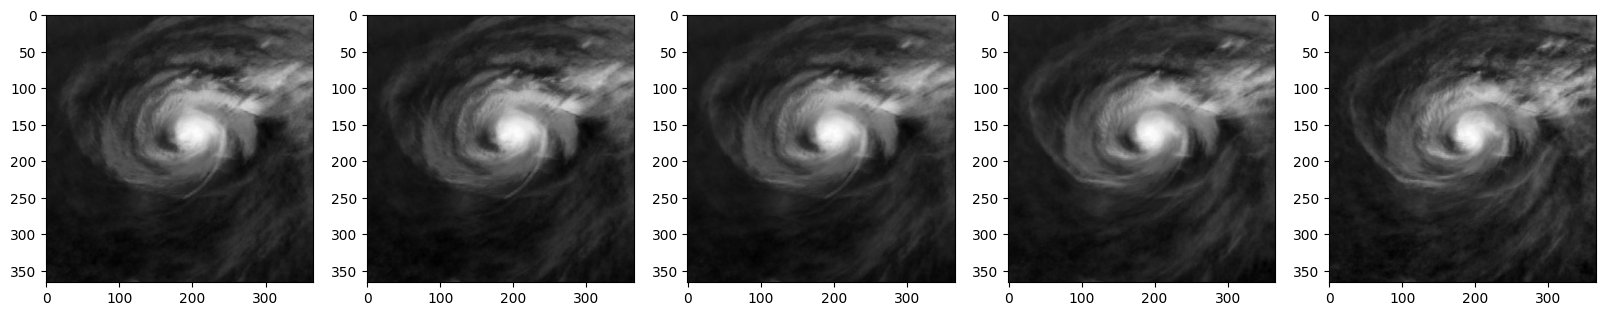

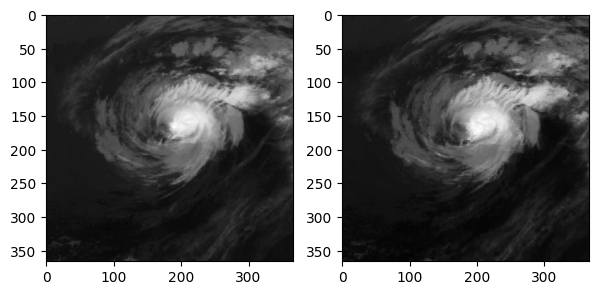

In [27]:
result = pca.inverse_transform(X_pca_copy)[-sequence_length:].reshape(sequence_length, 366, 366)
fig, ax = plt.subplots(1, sequence_length, figsize=(20, 20))
for i in range(sequence_length):
    ax[i].imshow(result[i], cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(7,7))
for i in range(2):
    ax[i].imshow(imread(files[i+num_images]), cmap='gray')

## ConvLSTM

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import InterpolationMode
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os
import json


### Image prep

In [4]:
class ImageSequenceDataset(Dataset):
    def __init__(self, directory, sequence_length=5, transform=None):
        self.directory = directory
        self.sequence_length = sequence_length
        self.transform = transform
        self.image_files = sorted(
            [f for f in os.listdir(directory) if f.endswith('.jpg')],
            key=lambda x: int(x.split('_')[1].split('.')[0])
        )

    def __len__(self):
        return len(self.image_files) - self.sequence_length

    def __getitem__(self, idx):
        sequence_files = self.image_files[idx:idx + self.sequence_length + 1]
        images = [read_image(os.path.join(self.directory, f)) for f in sequence_files]
        images = torch.stack(images).float() / 255.0  # Normalize the images
        if self.transform:
            images = torch.stack([self.transform(img) for img in images])  # Apply transforms to each image in sequence
        # Return a sequence and the next image
        return images[:-1], images[-1]


In [42]:
transform = transforms.Compose([
    transforms.Resize((366, 366)),

])

# Creating datasets and dataloaders
sequence_length = 5
batch_size = 3
dataset = ImageSequenceDataset('/content/drive/MyDrive/acds-the-day-after-tomorrow-olga/tst', sequence_length, transform)


# Calculate the size of the training and test sets
total_size = len(dataset)
train_size = int(total_size * 0.9)
test_size = total_size - train_size

# Random split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating the DataLoader for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# len(dataset)


247

### Model definition

In [6]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        # Apply the floor division to each element of the kernel_size tuple
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=device))


In [7]:
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=True, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size,
                                          bias=self.bias))
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        # Assuming input_tensor is of shape (batch, seq_len, channels, height, width)
        if not self.batch_first:
            # Convert to (batch, seq_len, channels, height, width)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        if hidden_state is None:
            # Initialize hidden state if not provided
            hidden_state = [self.cell_list[i].init_hidden(b, (h, w)) for i in range(self.num_layers)]

        current_input = input_tensor
        layer_output_list = []
        last_state_list = []

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(current_input.size(1)):
                h, c = self.cell_list[layer_idx](current_input[:, t, :, :, :], (h, c))
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            current_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list



We modified the network structure in the [Convolutional LSTM Network paper](https://dl.acm.org/doi/10.5555/2969239.2969329) to make ConvLSTM more suitable for our task.

### SSIM?

In [8]:
# Self define ssim function for training
def ssim(img1, img2, window_size=11, size_average=True):
    device = img1.device  # Device setting

    # Make sure input is float
    img1 = img1.float()
    img2 = img2.float()

    # Create SSIM window
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    window = torch.ones(1, 1, window_size, window_size, device=device)  # Create windows and move to device
    window /= window.sum()

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=1)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=1)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=1) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=1) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

We considered using SSIM for our model, as SSIM represents structural similarity (our intuition was that would help us produce better images). In the end, we found that it makes no noticeable difference to the results, while increasing the complexity of the training run.

SSIM code from https://github.com/VainF/pytorch-msssim based on this paper: https://www.cns.nyu.edu/pub/lcv/wang03-reprint.pdf

### Training run

In [9]:
convlstm = ConvLSTM(input_dim=1,
                    hidden_dim=[64, 64, 1], # Define the number of channels for hidden states
                    kernel_size=(3, 3), # Kernel size for each ConvLSTMCell
                    num_layers=3, # Number of ConvLSTM layers
                    batch_first=True,
                    bias=True,
                    return_all_layers=False)


convlstm = convlstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(convlstm.parameters(), lr=1e-3)

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    for sequence, next_frame in train_dataloader:
        sequence = sequence.to(device)
        next_frame = next_frame.to(device)
        optimizer.zero_grad()

        output, _ = convlstm(sequence)
        last_layer_output = output[-1]  # Get the output from the final layer

        # Select only the last output of the sequence
        last_output_frame = last_layer_output[:, -1, :, :, :]

        # Check shapes
        # print("Last output frame shape:", last_output_frame.shape)
        # print("Next frame shape:", next_frame.shape)

        # Try other loss function
        # loss = -ssim(last_output_frame, next_frame)
        loss = criterion(last_output_frame, next_frame)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}: Loss = {loss.item()}')


Epoch 1: Loss = 0.010976403951644897
Epoch 2: Loss = 0.008124126121401787
Epoch 3: Loss = 0.005556464660912752
Epoch 4: Loss = 0.005033059976994991
Epoch 5: Loss = 0.004819802939891815
Epoch 6: Loss = 0.004835415165871382
Epoch 7: Loss = 0.004702853970229626
Epoch 8: Loss = 0.004688304848968983
Epoch 9: Loss = 0.004648270551115274
Epoch 10: Loss = 0.004630002658814192


In [12]:
# Set model to eval()
convlstm.eval()

# Set test loss
test_loss = 0

with torch.no_grad():
    for sequence, next_frame in test_dataloader:
        sequence = sequence.to(device)
        next_frame = next_frame.to(device)

        output, _ = convlstm(sequence)
        last_layer_output = output[-1]  # Get the output from the final layer
        last_output_frame = last_layer_output[:, -1, :, :, :]

        # Try other loss function
        # loss = -ssim(last_output_frame, next_frame)
        loss = criterion(last_output_frame, next_frame)
        test_loss += loss.item()

test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss}')


Test Loss: 0.00584254331058926


### Results

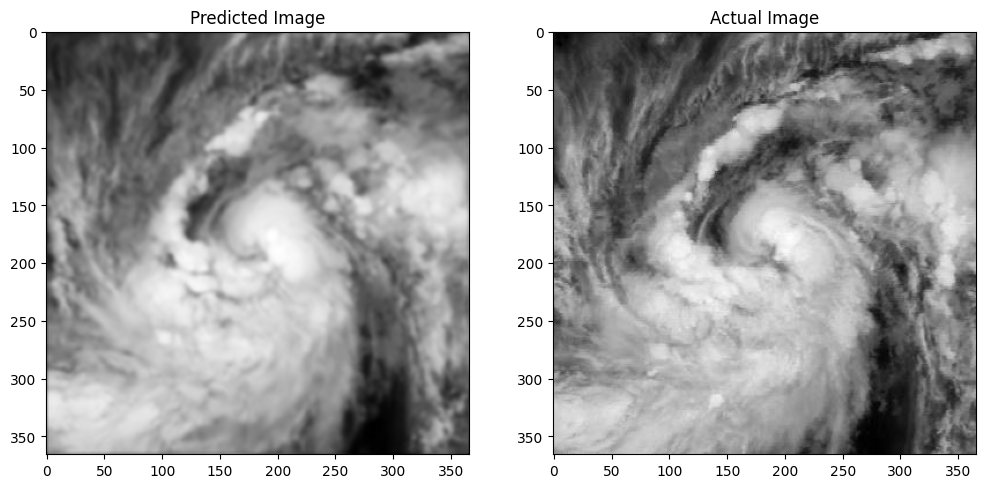

In [35]:
import matplotlib.pyplot as plt

# Make sure model is eval()
convlstm.eval()

# Random select a sample to test
test_sequence, test_next_frame = next(iter(test_dataloader))

# Move sample to device
test_sequence = test_sequence.to(device)

# Perform prediction
with torch.no_grad():
    output, _ = convlstm(test_sequence)
    predicted_frame = output[-1][:, -1, :, :, :]

# Move predicted and actual images back to the CPU and convert to numpy arrays
predicted_frame = predicted_frame.cpu().squeeze().numpy()
test_next_frame = test_next_frame.cpu().squeeze().numpy()

# Visualization of predicted and actual images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(predicted_frame[0], cmap='gray')
axes[0].set_title("Predicted Image")
axes[1].imshow(test_next_frame[0], cmap='gray')
axes[1].set_title("Actual Image")
plt.show()


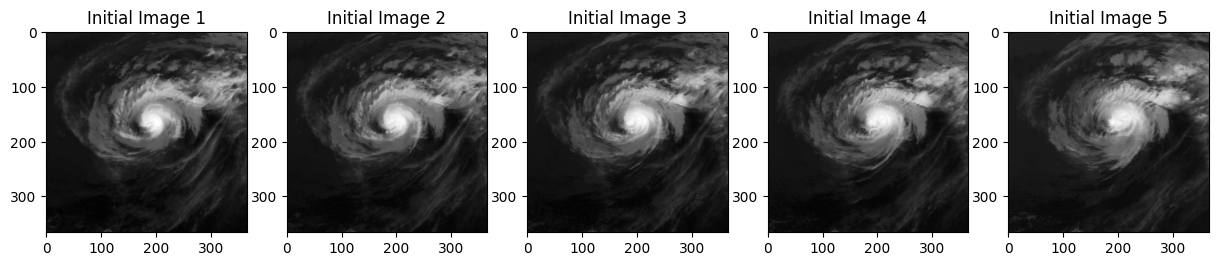

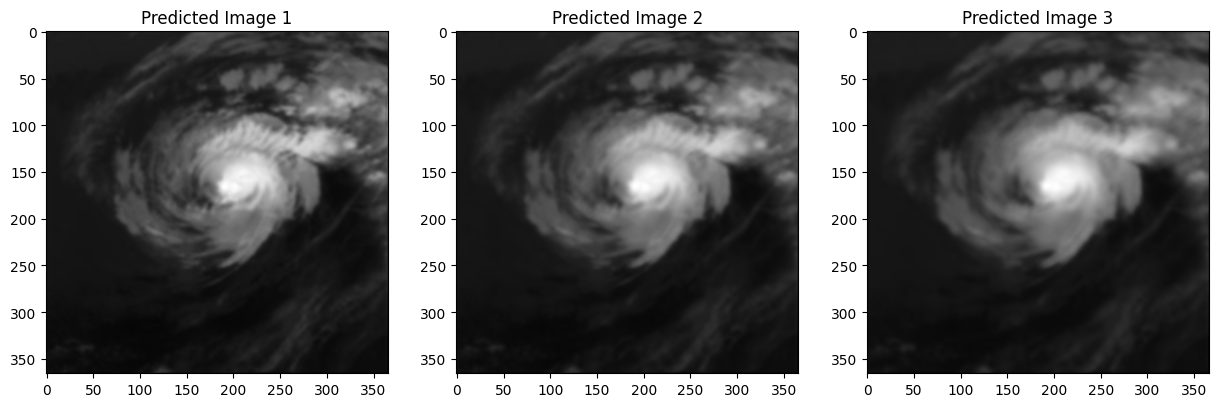

246


In [43]:
# Get the last few images of the dataset as the initial sequence
last_seq_idx = len(dataset)-1
initial_sequence, _ = dataset[last_seq_idx]
initial_sequence = initial_sequence.unsqueeze(0).to(device)  # Add batch dimension and move to device

predicted_images = []
current_sequence = initial_sequence

for _ in range(3):  # Predicting three images
    with torch.no_grad():
        convlstm.eval()
        output, _ = convlstm(current_sequence)
        next_image = output[-1][:, -1, :, :, :]  # Get the predicted next image
        predicted_images.append(next_image.squeeze(0).cpu())  # Storing predicted images

        # Update sequence: remove the oldest images and add the latest predicted images
        current_sequence = torch.cat((current_sequence[:, 1:, :, :, :], next_image.unsqueeze(1)), dim=1)

# Plotting the last few images in the dataset
fig, axes = plt.subplots(1, dataset.sequence_length, figsize=(15, 5))
for i in range(dataset.sequence_length):
    # Removing single-channel dimensions using the squeeze method
    image_data = initial_sequence[0, i].cpu().numpy().squeeze()
    axes[i].imshow(image_data, cmap='gray')  # Assuming a single-channel grayscale map
    axes[i].set_title(f"Initial Image {i+1}")
plt.show()


# Plotting the predicted image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, predicted_image in enumerate(predicted_images):
    axes[i].imshow(predicted_image[0], cmap='gray')  # Assuming a single-channel grayscale map
    axes[i].set_title(f"Predicted Image {i+1}")
plt.show()

print(last_seq_idx)

### Save the model

In [18]:
# Save the model state dictionary
torch.save(convlstm.state_dict(), '/content/drive/MyDrive/acds-the-day-after-tomorrow-olga/convlstm_model.pth')


### A gif

<img src="media/comparison_convlstm.gif" width="750" align="center">

### Analysis

This seems to be our best model, as it produces crisp results and shows movement of the cyclone.

## SimVP

### Model Definition

In [ ]:
import torch
from torch import nn


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]

class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

This model architecture was taken from the following repo: https://github.com/A4Bio/SimVP and is adapted from the SimVP paper: https://arxiv.org/abs/2206.05099

### Prepare the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
from PIL import Image

base_path = '/content/drive/MyDrive/storms_olga/bkh'
subdirectories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Structure to store images along with their directory name and image number
dataset = []

files = sorted(glob.glob(os.path.join(base_path, '*.jpg')))
for filepath in files:
    img = np.array(Image.open(filepath))

    # Extract the image number from the filename
    filename = os.path.basename(filepath)  # e.g., "directoryname_number.jpg"
    image_number = filename.split('.')[0].split('_')[-1]  # Extracts the number part

    # Add the image along with its directory name and number to the dataset
    dataset.append({'number': image_number, 'image': img})

# Convert dataset to a numpy array if needed (optional, depending on further use)
# dataset = np.array(dataset)  # Be cautious, as this may not work directly due to varying image sizes and the mixed data types

In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        num_images = len(self.dataset)
        for i in range(0, num_images - 8, 8):  # Assuming we have enough images for this range
            x_indices = list(range(i, i + 5))   # Indices for X
            y_indices = list(range(i + 5, i + 8))  # Indices for Y
            samples.append((x_indices, y_indices))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_indices, y_indices = self.samples[idx]
        X = self._load_images(x_indices)
        Y = self._load_images(y_indices)

        return X, Y

    def _load_images(self, indices):
        images = []
        for index in indices:
            # Extract the image array from the dataset
            image_array = self.dataset[index]['image']
            image = Image.fromarray(image_array)  # Convert NumPy array to PIL Image
            if self.transform:
                image = self.transform(image)
            images.append(image)

        images = torch.stack(images)
        return images

# Usage example
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Assuming 'dataset' is the modified dataset as a list of dictionaries
custom_dataset = CustomImageDataset(dataset, transform=transform)

from torch.utils.data import random_split

# Assuming custom_dataset is already created
dataset_size = len(custom_dataset)
test_size = int(0.1 * dataset_size)  # 10% for testing
train_size = dataset_size - test_size

train_data, test_data = random_split(custom_dataset, [train_size, test_size])

### Training run

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from livelossplot import PlotLosses
from kornia.losses import SSIM3DLoss
model = SimVP([5, 1, 128, 128], N_S = 3).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = SSIM3DLoss(3)
num_epochs = 20
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# Initialize PlotLosses instance
liveloss = PlotLosses()

for epoch in range(1, 100):
    print("Started epoch", epoch)
    train_loss = 0
    model.train()

    for batch_num, (input, target) in enumerate(train_dataloader, 1):
        input, target = input.to("cuda"), target.to("cuda")
        output = model(input)
        loss = criterion(output[:, :3, :, :, :], target[:, :3, :, :, :])

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation phase
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for input, target in test_dataloader:
            input, target = input.to("cuda"), target.to("cuda")
            output = model(input)
            loss = criterion(output[:, :3, :, :, :], target[:, :3, :, :, :])
            val_loss += loss.item()
    val_loss /= len(test_dataloader)

    # Log the loss for the livelossplot
    liveloss.update({'loss': train_loss, 'val_loss': val_loss})
    liveloss.send()

    print("Finished epoch", epoch)

### Results

<img src="media/comparison_simvp.gif" width="750" align="center">

### Analysis



Ultimately, while this model looked promising, it ended up giving us blurry results. The research paper that introduced it mentioned that the training run was done over 2k epochs, which we did not have time to achieve.

As a potential future exploration, this model should be run for the appropriate amount of time.